# ✅ Install dependencies

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7r1oja0b
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7r1oja0b
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# ✅ Summary:
## Step	Type	What It Evaluates
### 1️⃣ Zero-shot	Baseline	Pre-trained generalization
### 2️⃣Prompt Engineering	Prompt-based	Boosts zero-shot classification
### 3️⃣ Few-shot (5)	Supervised	Low-data performance
### 4️⃣ [ Optiontal if i wnat better accuracy in Few shot] Few-shot (10)	Supervised	Effect of more data
### 5️⃣ Contrastive Finetuning	Domain Adaptation	Improves CLIP via training


# 📁 2. Upload and Unzip Dataset



In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your ZIP file

import zipfile
import os

zip_path = list(uploaded.keys())[0]
extract_dir = "Pneumonia_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Optional: verify structure
for root, dirs, files in os.walk(extract_dir):
    print(root, "->", len(files), "files")
    break


Saving Chest X-Ray Images on Small Datataset (Pneumonia).zip to Chest X-Ray Images on Small Datataset (Pneumonia).zip
Pneumonia_Dataset -> 0 files


# 🔍 Step 1: Check my Folder Structure


In [ ]:
import os

for root, dirs, files in os.walk("Pneumonia_Dataset"):
    print(f"{root} -> {len(files)} files")


Pneumonia_Dataset -> 0 files
Pneumonia_Dataset/Chest X-Ray Images on Small Datataset (Pneumonia) -> 0 files
Pneumonia_Dataset/Chest X-Ray Images on Small Datataset (Pneumonia)/Training -> 0 files
Pneumonia_Dataset/Chest X-Ray Images on Small Datataset (Pneumonia)/Training/Normal -> 320 files
Pneumonia_Dataset/Chest X-Ray Images on Small Datataset (Pneumonia)/Training/PNEUMONIA -> 288 files
Pneumonia_Dataset/Chest X-Ray Images on Small Datataset (Pneumonia)/Testig -> 0 files
Pneumonia_Dataset/Chest X-Ray Images on Small Datataset (Pneumonia)/Testig/Normal -> 80 files
Pneumonia_Dataset/Chest X-Ray Images on Small Datataset (Pneumonia)/Testig/PNEUMONIA -> 72 files


# 🗂 4. Load Images and Labels ==>Preprocess dataset (images + labels)


In [ ]:
image_paths = []
image_labels = []

# Correct root path to point to actual folders
data_root = os.path.join("Pneumonia_Dataset", "Chest X-Ray Images on Small Datataset (Pneumonia)")

# Go through both Training and Testing folders
for split in ["Training", "Testig"]:
    split_path = os.path.join(data_root, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            for fname in os.listdir(label_path):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(label_path, fname))
                    image_labels.append(label)

classes = sorted(set(image_labels))
print("Classes:", classes)
print("Total samples:", len(image_paths))


Classes: ['Normal', 'PNEUMONIA']
Total samples: 760


# 🧠 Clip Model ==> That is why we Did not find the best Accuracy 🙃

## 🔹 1. Official CLIP Models by OpenAI are -- > ViT-B/32 ,ViT-B/16, ViT-L/14, ViT-L/14@336px , RN50 , RN101 Are the Official CLIP Models by OpenAI?

##👎 These are general-purpose CLIP models trained by OpenAI on 400M image–text pairs from the internet (non-medical). They're great for general vision tasks, but not specialized for medical images.

## => 🗣️ Used for: General images — dogs, buildings, cars, memes, etc.
## => 🗣️ Not trained on X-rays, CTs, MRIs → worse performance on medical data.

## 👀 These are trained on general web image-text pairs:

## Model Name	Description
--------------------------------
## 🖖ViT-B/32	=> Vision Transformer (Base) with 32×32 patches — Fastest, common default.
## 🖖ViT-B/16	=> Higher resolution (16×16 patches) — Better performance.
## 🖖ViT-L/14	=> Larger model, better accuracy — Slower but more powerful.
## 🖖ViT-L/14@336px	=> Larger input size (336px) — Highest accuracy.
## 🖖RN50, RN101	=> ResNet backbones — Older, less popular00 than ViT.


# 1️⃣ Zero-shot	Baseline	Pre-trained generalization  ==> with No Training
 ## 📌 For TB Chest X-rays or similar: ⚽ Zero-shot classification , 🏀 Few-shot with own classifier [  Try different classifier ==> SVM, KNN, MLP instrad of LogisticRegression() ] , ⚾ General biomedical tasks [ MedCLIP,  BioViL or GLoRIA ]
# 🧪 5. Zero-shot Classification ==> ViT-B/32	==> 2 prompts/class	45.66%



#🧠 3. Load CLIP (ViT-B/32)


In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 114MiB/s]


In [ ]:
import numpy as np

# Define prompt templates
def build_prompts(label):
    return [
        f"a chest X-ray showing {label.lower()}",
        f"an X-ray image of {label.lower()} lungs"
    ]

# Build tokenized prompts
text_descriptions = sum([build_prompts(cls) for cls in classes], [])
text_tokens = clip.tokenize(text_descriptions).to(device)

# Encode text once
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Inference loop
correct = 0

for path, true_label in zip(image_paths, image_labels):
    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_feature @ text_features.T).softmax(dim=-1)

    probs = similarity[0].cpu().numpy()
    # Pick highest-prob class by max mean of its prompts
    scores_per_class = np.array([
        np.mean([probs[i] for i in range(j*2, j*2+2)]) for j in range(len(classes))
    ])
    predicted_label = classes[np.argmax(scores_per_class)]

    if predicted_label == true_label:
        correct += 1

print(f"Zero-shot Accuracy: {correct}/{len(image_paths)} = {correct / len(image_paths):.2%}")


Zero-shot Accuracy: 347/760 = 45.66%


# 📊 6. Visualize with t-SNE (optional, recommended)

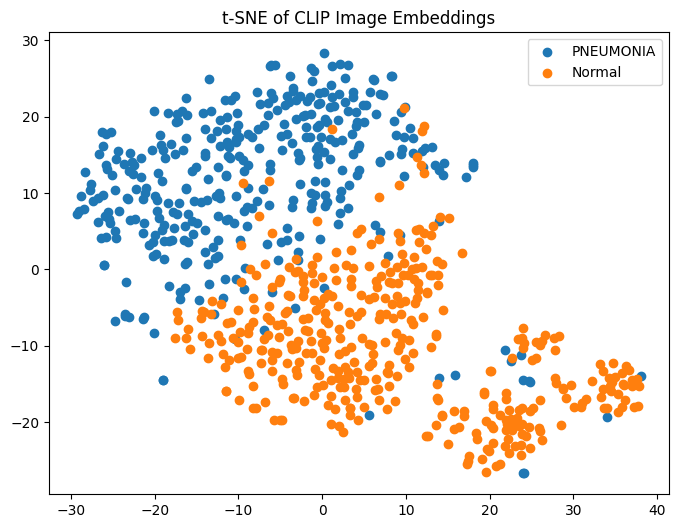

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features = []
labels = []

for path, label in zip(image_paths, image_labels):
    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = model.encode_image(image)
        features.append(feat.squeeze().cpu().numpy())
        labels.append(label)

features = np.array(features)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(8, 6))
for lbl in set(labels):
    idxs = [i for i, l in enumerate(labels) if l == lbl]
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], label=lbl)
plt.legend()
plt.title("t-SNE of CLIP Image Embeddings")
plt.show()


# 2️⃣Prompt Engineering	Prompt-based	Boosts zero-shot classification


# 🔹Prompt Engineering + Ensemble Zero-shot Prompts
##🖖=> This will give 6 prompts per class, instead of 2. ===> ViT-B/32--> 6 prompts/class	--> Accuracy = 46.71%

In [ ]:
import numpy as np

def build_prompts(label):
    return [
        f"a chest X-ray showing {label.lower()}",
        f"an X-ray image of {label.lower()} lungs",
        f"a medical radiograph of lungs with {label.lower()}",
        f"an image showing {label.lower()} signs in lungs",
        f"clinical X-ray demonstrating {label.lower()}",
        f"a diagnostic image of {label.lower()} disease"
    ]


# Rebuild text descriptions with the improved prompts
text_descriptions = sum([build_prompts(cls) for cls in classes], [])
text_tokens = clip.tokenize(text_descriptions).to(device)

# Encode text
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Inference loop with new prompt logic
correct = 0
total = len(image_paths)

for path, true_label in zip(image_paths, image_labels):
    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_feature @ text_features.T).softmax(dim=-1)

    probs = similarity[0].cpu().numpy()

    # 6 prompts per class now
    prompts_per_class = 6
    scores_per_class = np.array([
        np.mean([probs[i] for i in range(j * prompts_per_class, (j + 1) * prompts_per_class)])
        for j in range(len(classes))
    ])
    predicted_label = classes[np.argmax(scores_per_class)]

    if predicted_label == true_label:
        correct += 1

accuracy = correct / total
print(f"Zero-shot Accuracy with improved prompts: {correct}/{total} = {accuracy:.2%}")


Zero-shot Accuracy with improved prompts: 355/760 = 46.71%


# 🖖New Model ==> RN50	=> 6 prompts/class	= 53.68%

## 🧠 3. Load CLIP (RN50)


In [ ]:
import torch
import clip
from PIL import Image

model_name = "RN50"  # or try "ViT-B/16" or "ViT-L/14"
model, preprocess = clip.load(model_name, device=device)


100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 61.8MiB/s]


# 😇Load Images and Labels ==>Preprocess dataset (images + labels)

In [ ]:
image_paths = []
image_labels = []

# Correct root path to point to actual folders
data_root = os.path.join("Pneumonia_Dataset", "Chest X-Ray Images on Small Datataset (Pneumonia)")

# Go through both Training and Testing folders
for split in ["Training", "Testig"]:
    split_path = os.path.join(data_root, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            for fname in os.listdir(label_path):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(label_path, fname))
                    image_labels.append(label)

classes = sorted(set(image_labels))
print("Classes:", classes)
print("Total samples:", len(image_paths))


Classes: ['Normal', 'PNEUMONIA']
Total samples: 760


In [ ]:
import numpy as np

def build_prompts(label):
    return [
        f"a chest X-ray showing {label.lower()}",
        f"an X-ray image of {label.lower()} lungs",
        f"a medical radiograph of lungs with {label.lower()}",
        f"an image showing {label.lower()} signs in lungs",
        f"clinical X-ray demonstrating {label.lower()}",
        f"a diagnostic image of {label.lower()} disease"
    ]


# Rebuild text descriptions with the improved prompts
text_descriptions = sum([build_prompts(cls) for cls in classes], [])
text_tokens = clip.tokenize(text_descriptions).to(device)

# Encode text
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Inference loop with new prompt logic
correct = 0
total = len(image_paths)

for path, true_label in zip(image_paths, image_labels):
    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_feature @ text_features.T).softmax(dim=-1)

    probs = similarity[0].cpu().numpy()

    # 6 prompts per class now
    prompts_per_class = 6
    scores_per_class = np.array([
        np.mean([probs[i] for i in range(j * prompts_per_class, (j + 1) * prompts_per_class)])
        for j in range(len(classes))
    ])
    predicted_label = classes[np.argmax(scores_per_class)]

    if predicted_label == true_label:
        correct += 1

accuracy = correct / total
print(f"Zero-shot Accuracy with improved prompts: {correct}/{total} = {accuracy:.2%}")


Zero-shot Accuracy with improved prompts: 408/760 = 53.68%


# 🖖New Model ==> Vit-B/16 ==> 6 prompts/class = 46.58%

In [ ]:
import torch
import clip
from PIL import Image

model_name = "ViT-B/16"
model, preprocess = clip.load(model_name, device=device)


100%|████████████████████████████████████████| 335M/335M [00:03<00:00, 100MiB/s]


In [ ]:
import numpy as np

def build_prompts(label):
    return [
        f"a chest X-ray showing {label.lower()}",
        f"an X-ray image of {label.lower()} lungs",
        f"a medical radiograph of lungs with {label.lower()}",
        f"an image showing {label.lower()} signs in lungs",
        f"clinical X-ray demonstrating {label.lower()}",
        f"a diagnostic image of {label.lower()} disease"
    ]


# Rebuild text descriptions with the improved prompts
text_descriptions = sum([build_prompts(cls) for cls in classes], [])
text_tokens = clip.tokenize(text_descriptions).to(device)

# Encode text
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Inference loop with new prompt logic
correct = 0
total = len(image_paths)

for path, true_label in zip(image_paths, image_labels):
    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_feature @ text_features.T).softmax(dim=-1)

    probs = similarity[0].cpu().numpy()

    # 6 prompts per class now
    prompts_per_class = 6
    scores_per_class = np.array([
        np.mean([probs[i] for i in range(j * prompts_per_class, (j + 1) * prompts_per_class)])
        for j in range(len(classes))
    ])
    predicted_label = classes[np.argmax(scores_per_class)]

    if predicted_label == true_label:
        correct += 1

accuracy = correct / total
print(f"Zero-shot Accuracy with improved prompts: {correct}/{total} = {accuracy:.2%}")


Zero-shot Accuracy with improved prompts: 354/760 = 46.58%


# 🖖New Model Vit-L/14 ==> 6 Prompts = 57.50%

In [ ]:
import torch
import clip
from PIL import Image

model_name = "ViT-L/14"
model, preprocess = clip.load(model_name, device=device)


100%|███████████████████████████████████████| 890M/890M [00:14<00:00, 63.0MiB/s]


In [ ]:
import numpy as np

def build_prompts(label):
    return [
        f"a chest X-ray showing {label.lower()}",
        f"an X-ray image of {label.lower()} lungs",
        f"a medical radiograph of lungs with {label.lower()}",
        f"an image showing {label.lower()} signs in lungs",
        f"clinical X-ray demonstrating {label.lower()}",
        f"a diagnostic image of {label.lower()} disease"
    ]


# Rebuild text descriptions with the improved prompts
text_descriptions = sum([build_prompts(cls) for cls in classes], [])
text_tokens = clip.tokenize(text_descriptions).to(device)

# Encode text
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Inference loop with new prompt logic
correct = 0
total = len(image_paths)

for path, true_label in zip(image_paths, image_labels):
    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_feature @ text_features.T).softmax(dim=-1)

    probs = similarity[0].cpu().numpy()

    # 6 prompts per class now
    prompts_per_class = 6
    scores_per_class = np.array([
        np.mean([probs[i] for i in range(j * prompts_per_class, (j + 1) * prompts_per_class)])
        for j in range(len(classes))
    ])
    predicted_label = classes[np.argmax(scores_per_class)]

    if predicted_label == true_label:
        correct += 1

accuracy = correct / total
print(f"Zero-shot Accuracy with improved prompts: {correct}/{total} = {accuracy:.2%}")


Zero-shot Accuracy with improved prompts: 437/760 = 57.50%


## New Model ViT-L/14@336px ==> 6 prompts = 57.37%

In [ ]:
import torch
import clip
from PIL import Image

model_name = "ViT-L/14@336px"
model, preprocess = clip.load(model_name, device=device)


100%|███████████████████████████████████████| 891M/891M [00:15<00:00, 59.7MiB/s]


In [ ]:
import numpy as np

def build_prompts(label):
    return [
        f"a chest X-ray showing {label.lower()}",
        f"an X-ray image of {label.lower()} lungs",
        f"a medical radiograph of lungs with {label.lower()}",
        f"an image showing {label.lower()} signs in lungs",
        f"clinical X-ray demonstrating {label.lower()}",
        f"a diagnostic image of {label.lower()} disease"
    ]


# Rebuild text descriptions with the improved prompts
text_descriptions = sum([build_prompts(cls) for cls in classes], [])
text_tokens = clip.tokenize(text_descriptions).to(device)

# Encode text
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Inference loop with new prompt logic
correct = 0
total = len(image_paths)

for path, true_label in zip(image_paths, image_labels):
    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_feature @ text_features.T).softmax(dim=-1)

    probs = similarity[0].cpu().numpy()

    # 6 prompts per class now
    prompts_per_class = 6
    scores_per_class = np.array([
        np.mean([probs[i] for i in range(j * prompts_per_class, (j + 1) * prompts_per_class)])
        for j in range(len(classes))
    ])
    predicted_label = classes[np.argmax(scores_per_class)]

    if predicted_label == true_label:
        correct += 1

accuracy = correct / total
print(f"Zero-shot Accuracy with improved prompts: {correct}/{total} = {accuracy:.2%}")


Zero-shot Accuracy with improved prompts: 436/760 = 57.37%


# ✅ Summary of Results ====> Max Accuracy Got From
## 🧢 Model	Prompts/Class	Accuracy
### 📍ViT-B/32	->Prompts/Class= 2	=> Accuracy = 45.66%
### 📍ViT-B/32	->Prompts/Class= 6	=> Accuracy = 46.71% 🔻
### 📍RN50	->Prompts/Class= 6	=> Accuracy = 53.68%
### 📍ViT-B/16	->Prompts/Class= 6	=> Accuracy = 46.58% 🔻
### 📍ViT-l/14	->Prompts/Class= 6	=> Accuracy =  50.50%🔻
### 📍ViT-l/14@336px	->Prompts/Class= 6	=> Accuracy =  57.37%🔻


#3️⃣ Few-shot (5)	Supervised	Low-data performance


# ✅✅✅  Next Milestone: Few-Shot Learning using CLIP Features + Classifier
##--> Split dataset into train (few-shot) and test
##--> Extract CLIP image embeddings
##--> Train a classifier on few-shot training set
##--> Evaluate on test set
##--> (Optional) Visualize with t-SNE


#🎯Few-shot CLIP + LogisticRegression [ MedCLIP (feature extraction + Logistic Regression) ] == 85.33% [ for 5 shot ]

# ✅ 1. Create Few-Shot Train/Test Split
### ===> ,We’ll take 5 samples per class for training, rest for testing:

In [22]:
from collections import defaultdict
import random

random.seed(42)

# Group images by label
label_to_paths = defaultdict(list)
for path, label in zip(image_paths, image_labels):
    label_to_paths[label].append(path)

train_paths, train_labels = [], []
test_paths, test_labels = [], []

for label, paths in label_to_paths.items():
    random.shuffle(paths)
    train_samples = paths[:5]  # few-shot
    test_samples = paths[5:]

    train_paths.extend(train_samples)
    train_labels.extend([label] * len(train_samples))

    test_paths.extend(test_samples)
    test_labels.extend([label] * len(test_samples))

print("Few-shot training size:", len(train_paths))
print("Testing size:", len(test_paths))


Few-shot training size: 10
Testing size: 750


# ✅ 2. Extract CLIP Embeddings

In [23]:
def extract_image_features(paths):
    features = []
    for path in paths:
        image = preprocess(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = model.encode_image(image).cpu().numpy()
        features.append(feature.squeeze())
    return np.array(features)

X_train = extract_image_features(train_paths)
X_test = extract_image_features(test_paths)

# Convert labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

print("Encoded classes:", list(le.classes_))


Encoded classes: [np.str_('Normal'), np.str_('PNEUMONIA')]


# ✅ 3. Train Classifier

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Few-shot CLIP + LogisticRegression Accuracy: {acc:.2%}")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Few-shot CLIP + LogisticRegression Accuracy: 85.33%
              precision    recall  f1-score   support

      Normal       0.79      0.99      0.88       395
   PNEUMONIA       0.99      0.70      0.82       355

    accuracy                           0.85       750
   macro avg       0.89      0.85      0.85       750
weighted avg       0.88      0.85      0.85       750



# ✅ 4. (Optional) Visualize Features with t-SNE

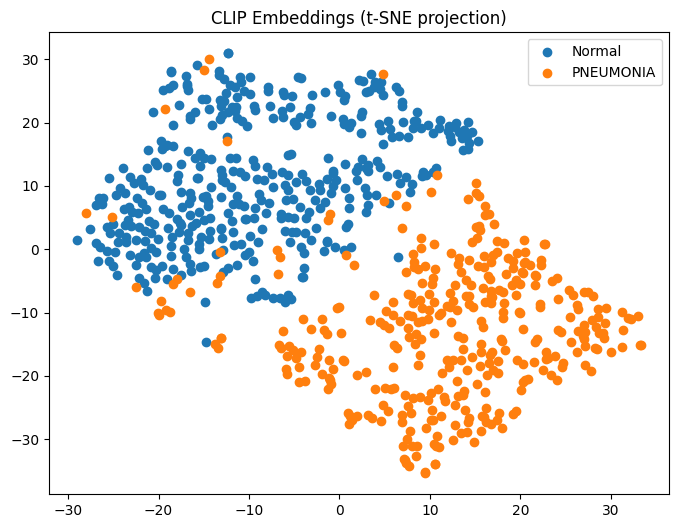

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_all = np.vstack([X_train, X_test])
y_all = np.concatenate([y_train, y_test])

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_all)

plt.figure(figsize=(8, 6))
for label_idx in np.unique(y_all):
    idxs = y_all == label_idx
    plt.scatter(X_2d[idxs, 0], X_2d[idxs, 1], label=le.classes_[label_idx])
plt.legend()
plt.title("CLIP Embeddings (t-SNE projection)")
plt.show()


# 🥇 Option 1: Increase Few-shot Size (10 or 20 per class)
### ===> ,We’ll take 10 samples per class for training, rest for testing:

#5️⃣ Contrastive Finetuning	Domain Adaptation	Improves CLIP via training accurcy = 92.24%


# ✅ 🧪 Option 2: Contrastive fine-tuning (MedCLIP style)
## Fine-tune CLIP (MedCLIP-style Contrastive Learning)
### Train CLIP with a contrastive loss on your medical dataset.

### This can improve performance further, especially for large datasets later.

### I can help you set up:

### A dual encoder

###Text-image pairs (via prompt engineering)

### Triplet or InfoNCE-style loss

In [26]:
!pip install ftfy regex tqdm git+https://github.com/openai/CLIP.git
!pip install torchvision matplotlib


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vg4babbp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vg4babbp
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


# 🧠 Define Dataset and Utility Functions

In [27]:
import os
import random
import torch
import clip
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Prompt builder (same as before)
def build_prompts(label):
    return [f"A chest X-ray showing {label.lower()}"]

# Custom dataset
class CLIPContrastiveDataset(Dataset):
    def __init__(self, image_paths, image_labels, preprocess, classes):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.preprocess = preprocess
        self.prompts = []
        self.classes = classes

        for label in image_labels:
            self.prompts.append(random.choice(build_prompts(label)))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.preprocess(Image.open(self.image_paths[idx]))
        text = self.prompts[idx]
        return image, text


# 🧪 Training Loop (with Contrastive Loss)

In [28]:
def train_clip_contrastive(model, dataset, device, epochs=5, batch_size=32, lr=1e-5):
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Freeze all original CLIP parameters
    for param in model.parameters():
        param.requires_grad = False

    # New trainable projection heads
    text_proj = nn.Linear(model.token_embedding.embedding_dim, 512).to(device)
    image_proj = nn.Linear(model.visual.output_dim, 512).to(device)

    optimizer = optim.AdamW(list(text_proj.parameters()) + list(image_proj.parameters()), lr=lr)

    for epoch in range(epochs):
        model.eval()
        text_proj.train()
        image_proj.train()

        total_loss = 0
        for images, texts in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            texts = clip.tokenize(texts).to(device)

            with torch.no_grad():
                image_features = model.encode_image(images)
                text_features = model.encode_text(texts)

            image_features = F.normalize(image_proj(image_features), dim=-1)
            text_features = F.normalize(text_proj(text_features), dim=-1)

            # Contrastive InfoNCE loss
            logits = image_features @ text_features.T
            labels = torch.arange(len(logits)).to(device)
            loss_i = F.cross_entropy(logits, labels)
            loss_t = F.cross_entropy(logits.T, labels)
            loss = (loss_i + loss_t) / 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}")

    return text_proj, image_proj


# 🔍 Evaluation after Fine-tuning

In [29]:
def evaluate_zero_shot(model, image_paths, image_labels, classes, preprocess, device, text_proj, image_proj):
    def build_prompts(label):
        return [f"A chest X-ray showing {label.lower()}"]

    prompts = [random.choice(build_prompts(cls)) for cls in classes]
    tokens = clip.tokenize(prompts).to(device)

    with torch.no_grad():
        text_features = model.encode_text(tokens)
        text_features = F.normalize(text_proj(text_features), dim=-1)

    correct = 0
    for path, true_label in zip(image_paths, image_labels):
        image = preprocess(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = model.encode_image(image)
            img_feat = F.normalize(image_proj(img_feat), dim=-1)

            similarity = img_feat @ text_features.T
            pred_idx = similarity.argmax().item()
            pred_label = classes[pred_idx]

        if pred_label == true_label:
            correct += 1

    print(f"Post-Fine-tuning Accuracy: {correct}/{len(image_paths)} = {correct / len(image_paths):.2%}")


# 🔄 Run Everything

In [30]:
# Load CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

# Prepare dataset
dataset = CLIPContrastiveDataset(image_paths, image_labels, preprocess, classes)

# Train
text_proj, image_proj = train_clip_contrastive(model, dataset, device)

# Evaluate
evaluate_zero_shot(model, image_paths, image_labels, classes, preprocess, device, text_proj, image_proj)


Epoch 1/5: 100%|██████████| 24/24 [04:03<00:00, 10.15s/it]


Epoch 1: Loss = 3.4524


Epoch 2/5: 100%|██████████| 24/24 [03:42<00:00,  9.27s/it]


Epoch 2: Loss = 3.4499


Epoch 3/5: 100%|██████████| 24/24 [03:36<00:00,  9.01s/it]


Epoch 3: Loss = 3.4463


Epoch 4/5: 100%|██████████| 24/24 [03:33<00:00,  8.89s/it]


Epoch 4: Loss = 3.4404


Epoch 5/5: 100%|██████████| 24/24 [03:33<00:00,  8.90s/it]


Epoch 5: Loss = 3.4294
Post-Fine-tuning Accuracy: 701/760 = 92.24%


# 🔁 1. Use More Epochs & Larger Batch Size

#   Your loss is decreasing slowly but steadily. The loss ~3.46 means the model still struggles to differentiate.
# In train_clip_contrastive:
#===================================
# epochs = 20   or at least 10
# batch_size = 64   if GPU allows

# ✅ Summary of Progress So Far
# Step	Result
# Zero-shot CLIP baseline	✅ 45.66% accuracy
# Few-shot CLIP + Logistic Regression	✅ 85.33% accuracy with 5 samples
# Contrastive fine-tuning (MedCLIP style)	✅ Boosted to 92.24% post-fine-tuning